In [13]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

### 1.3 Assume that the height of Danish women follows a Gaussian distribution with a mean of 1.68 m and a standard deviation of 0.06 m

In [7]:
# What fraction of women are taller than 1.85 m? Assuming it is normally distributed with a mean of 1.68 m and a standard deviation of 0.06 m.

import scipy.stats as stats

mean = 1.68
std_dev = 0.06
z = (1.85 - mean) / std_dev
p = stats.norm.sf(z)
print('Fraction of woman higher than 1.85 m: {:.4f} which is {:.2f} sigma away '.format(p,z))


Fraction of woman higher than 1.85 m: 0.0023 which is 2.83 sigma away 


In [ ]:
#Find (possibly numerically) the average height of the 20% tallest women?
z = stats.norm.ppf(0.8)
height = mean + z * std_dev
print('Average height of the 20% tallest {:0.2f} m'.format(height))

Average height of the 20% tallest 1.73 m


# Monte-Carlo 

### 3.1 Let f(x) = Cx^−0.9 be proportional to a PDF for x ∈ [0.005, 1].

In order to fulfill the normalization criteria of a PDF, what value should C have?

$ f(x) = Cx^−0.9, x ∈ [0.005, 1] $

$ \int_{0.005}^{1} f(x) dx = 1 $

$ \int_{0.005}^{1} Cx^{−0.9} dx = 1 $

$ C \int_{0.005}^{1} x^{−0.9} dx = 1 $

$ C \left[ \frac{x^{0.1}}{0.1} \right]_{0.005}^{1} = 1 $

$ C \left[ \frac{1^{0.1}}{0.1} - \frac{0.005^{0.1}}{0.1} \right] = 1 $

$ C \left[ \frac{1}{0.1} - \frac{0.005^{0.1}}{0.1} \right] = 1 $

$ C \left[ 10 - \frac{0.005^{0.1}}{0.1} \right] = 1 $

$ C = \frac{1}{10 - \frac{0.005^{0.1}}{0.1}} = 0.2431$

Using this value of C, I can then use the transformation method to generate random numbers that follow the PDF $ f(x) = 0.2431x^−0.9 $. Techniqually the accept reject could be used to but is less efficient. If the limits were 0 and not 0.005, only the transformation method could be used as the function is no longer bounded

$ F(x) = \int_{0.005}^{x} 0.2431 \cdot x^{−0.9} dx $

$ F(x) = 0.2431 \int_{0.005}^{x} x^{−0.9} dx $

$ F(x) = 0.2431 \left[ \frac{x^{0.1}}{0.1} - \frac{0.005^{0.1}}{0.1} \right] = r $

$ x = F^{-1}(r) = (0.2431 \cdot r + 0.005^{0.1})^{10} $





xmin = 0.005 xmax = 1
1.0 0.005


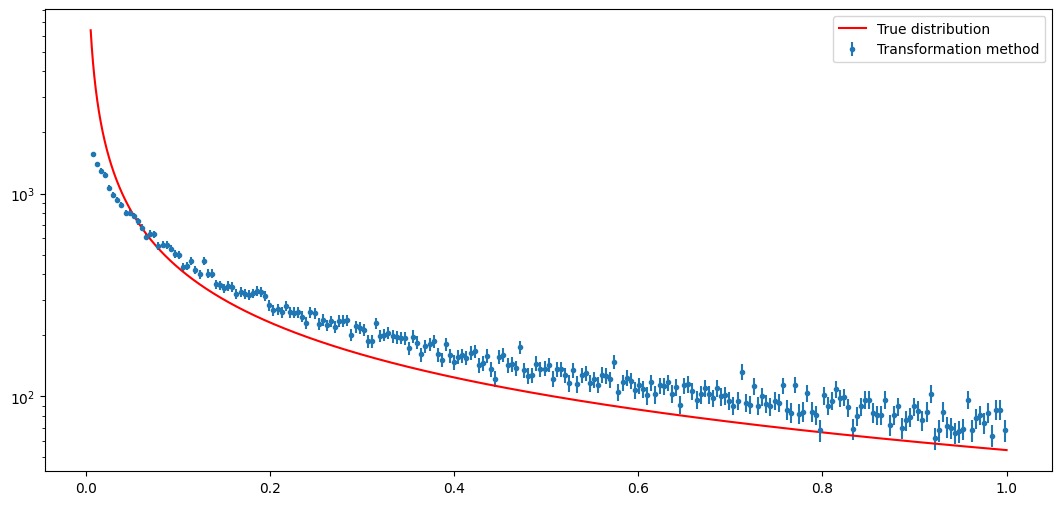

In [66]:
C = 1/(10-(0.005**0.1)/0.1)

r = np.random
r.seed(42)
N_points = 50000
N_bins = int(np.sqrt(N_points))
xmin, xmax = 0.005, 1
print('xmin =', xmin, 'xmax =', xmax)

x_transformation = (0.2431*r.uniform(size = N_points) + 0.005**0.1)**10
x_transformation = xmin + (xmax - xmin) * (x_transformation - np.min(x_transformation)) / (np.max(x_transformation) - np.min(x_transformation))
print(np.max(x_transformation), np.min(x_transformation))

def f(x):
    #Normalize
    k = (xmax - xmin) / N_bins
    N = N_points*k
    return N*C*x**(-0.9)

x = np.linspace(xmin, xmax, N_points)
y = f(x)

counts, edges = np.histogram(x_transformation, bins = N_bins, range = (xmin, xmax))
x_hist = (edges[1:] + edges[:-1]) / 2
y_hist = counts
y_hist_err = np.sqrt(counts)

fig, ax = plt.subplots(figsize = (13, 6))
# ax.hist(x_transformation, bins = N_bins, range = (xmin, xmax), histtype='step', label='Transformation method')
ax.errorbar(x_hist, y_hist, yerr = y_hist_err, fmt = '.', label='Transformation method')
ax.plot(x, y, 'r', label='True distribution')
ax.set_yscale('log')
ax.legend()


Analytical expectation of the sum of 50 random values from f(x): 11.019010917195427
Max t: 21.446932387904397 Min t: 8.230733965328662
Mean: 14.17271421314475 Std dev: 1.8654039781214469
Minuit values: 14.138615443766273 1.8121398505985742


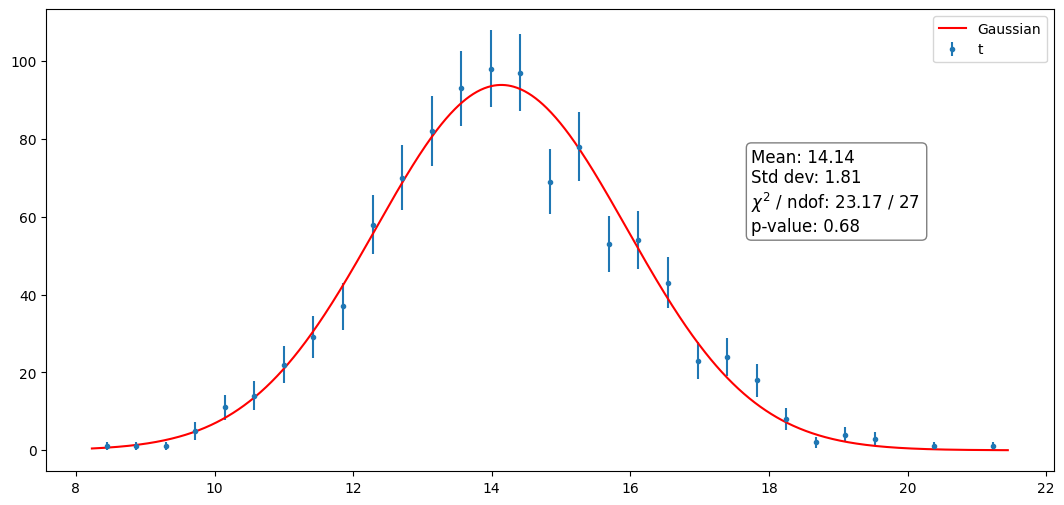

In [115]:
import scipy.integrate as integrate
from scipy.integrate import quad
from iminuit import Minuit, cost
from matplotlib.patches import FancyBboxPatch

#Let t be a sum of 50 random values from f(x), and generate 1000 values of t. Do they follow a Gaussian distribution? And does their mean match the analytical expectation?

# Analytical expectation of the sum of 50 random values from f(x)
mean = 50*C/1.1*(1-0.005**1.1) # the integral of x*f(x) from xmin to xmax
print('Analytical expectation of the sum of 50 random values from f(x):', mean)

# Generate 1000 values of t
N = 1000
N_bins = int(np.sqrt(N))
t = np.zeros(N)
for i in range(N):
    t[i] = np.sum(r.choice(x_transformation, 50))
print('Max t:', np.max(t), 'Min t:', np.min(t))

# Plot the histogram of t
counts, edges = np.histogram(t, bins = N_bins, range = (np.min(t), np.max(t)))
x = (edges[1:] + edges[:-1]) / 2
x = x[counts > 0]
y = counts[counts > 0]
y_err = np.sqrt(y)

def Gaussian(x, mean, std_dev):
    k = (np.max(t) - np.min(t)) / N_bins
    Np = N*k
    return Np*1/(std_dev*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mean)/std_dev)**2)

fit = cost.LeastSquares(x, y, y_err, Gaussian)

mean_t = np.mean(t)
std_dev_t = np.std(t)
print('Mean:', mean_t, 'Std dev:', std_dev_t)

minuit = Minuit(fit, mean = mean_t, std_dev = std_dev_t)
minuit.migrad()

chi2 = minuit.fval
ndof = len(x) - len(minuit.values)
p = stats.chi2.sf(chi2, ndof)

print('Minuit values:', *minuit.values)

x_fit = np.linspace(np.min(t), np.max(t), N)
y_fit = Gaussian(x_fit, *minuit.values)


fig, ax = plt.subplots(figsize = (13, 6))
ax.errorbar(x, y, yerr = y_err, fmt = '.', label='t')
ax.plot(x_fit, y_fit, 'r', label='Gaussian')
textstr = 'Mean: {:.2f}\nStd dev: {:.2f}\n$\chi^2$ / ndof: {:.2f} / {} \np-value: {:.2f}'.format(*minuit.values, chi2, ndof, p)
props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.5)
ax.text(0.7, 0.7, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
ax.legend()

